<a href="https://colab.research.google.com/github/RichardMWarburton/ExploringCUAD/blob/exploratory-analysis-16-06-21/Exploratory%20Data%20Analysis%20-%20PART%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis - PART 2

## The Data

CUAD: An Expert-Annotated NLP Dataset for Legal Contract Review

https://arxiv.org/abs/2103.06268

This code is an adaptation of the scrape.py file avaliable on the github repository for CUAD.  It has been adapted to run in Jypter notebooks and allow us to step throght the coding line by line.`

## Import Packages

In [360]:
from zipfile import ZipFile
import json
import os
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import re
from random import sample, choice
import numpy as np
import pandas as pd

## Download repository and extract data

In [361]:
def extract_zip(pth,data_pth = None):
    """Function to extract contents of a zip file to a specified location (wd if data_pth not passed)"""
    with ZipFile(pth, 'r') as zipObj:
       # Extract all the contents of zip file in different directory
       zipObj.extractall(data_pth)

In [362]:
#Download CUAD git repository
if not os.path.exists('main.zip'):
  !wget --no-check-certificate https://github.com/TheAtticusProject/cuad/archive/refs/heads/main.zip
  !unzip -q main.zip

#If it has not already been extracted, extract the contents of data.zip
if not os.path.exists('cuad-main/data'):
  os.makedirs('cuad-main/data')

if not os.path.exists('cuad-main/data/CUADv1.json'):
  extract_zip('cuad-main/data.zip','cuad-main/data/')

#Download a manualy curated set of labels for the full CUAD data. 
if not os.path.exists('labels3.txt'):
  !wget https://raw.githubusercontent.com/RichardMWarburton/ExploringCUAD/main/labels3.txt

In [363]:
#Load CUADv1 JSON to data
with open('cuad-main/data/CUADv1.json','r') as infile:
    for line in infile:
        contract_data = json.loads(line)

## Read in Label Data & Generate Look Up Dictionary

In [364]:
#Initate storage for labels look up (LU)
labels_LU = {}

#Read in labels data
with open('labels3.txt','r',encoding ='UTF-8') as infile:
  for line in infile:
    #Remove trailing special characters and split on tab
    data = line.strip().split(sep='\t')
    #Add name and label to labels_LU dictionary
    labels_LU[data[0]] = data[1]

The look up returns one error, most likely due to the accented E and a disparity of encoding.  This will be forced to 'Marketing Agreement' manually for now (EITHER SORT OR PROVIDE EXAMPLE)

## Extract Raw Contract Data

In [365]:
#ser reg ex expression for characters to remove from contract contest
spec_chars = '\\n|\\t|\\t'

#Set number of contracts in data
num_contracts = len(contract_data['data'])

#Initate dictionary to store raw contract data
raw_contracts = defaultdict(list)

#for each contract
for i in range(num_contracts):
  #Append the title, contract text and character length of text to the raw_contracts dictionary
  raw_contracts['contract title'].append(contract_data['data'][i]['title'])
  raw_contracts['label'].append(labels_LU[contract_data['data'][i]['title']] if contract_data['data'][i]['title'] in labels_LU else 'marketing agreement' ) #<- manual error trap applied here (see below)
  
  #Parse raw text and process to remove breaks
  raw_text = contract_data['data'][i]['paragraphs'][0]['context']
  clean_text = re.sub(spec_chars,'',raw_text)

  #Split clean text in to sentances and tokens
  sentance_text = clean_text.split(sep = '. ')
  token_text = clean_text.split(sep = ' ')

  #Append text to the respective key in the raw_contracts dictionary
  raw_contracts['raw text'].append(raw_text)
  raw_contracts['clean text'].append(clean_text)
  raw_contracts['sentance text'].append(sentance_text)
  raw_contracts['token text'].append(token_text)
  
  #Add character, sentance and token counts to raw_contracts dictionary
  raw_contracts['character count'].append(len(raw_text))
  raw_contracts['sentance count'].append(len(sentance_text))
  raw_contracts['token count'].append(len(token_text))


In [366]:
#Sanity check value lists for each key ahve the correct length (510)
for key in raw_contracts:
  print(key,len(raw_contracts[key]))

contract title 510
label 510
raw text 510
clean text 510
sentance text 510
token text 510
character count 510
sentance count 510
token count 510


## Extract Clause Specific Data

In [367]:
#Define the number of clauses
num_clauses = 41

#initate dictioanry to store caluse data
clause_data = defaultdict(list)

#For each contract
for i in range(num_contracts):
  #for each clause
  for j in range(num_clauses):
    #for each found clause annotation
    for k in range(len(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'])): 
      #Add the contract title
      clause_data['contract title'].append(contract_data['data'][i]['title'])
      clause_data['label'].append(labels_LU[contract_data['data'][i]['title']] if contract_data['data'][i]['title'] in labels_LU else 'marketing agreement' )  #<- manual error trap applied here
      clause_data['clause'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['id'].split(sep='__')[1])
      clause_data['annotation'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['text'])
      clause_data['annotation start'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['answer_start'])
      clause_data['annotation length'].append(len(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['text']))


In [368]:
#Sanity check value lists for each key ahve the correct length (13823)
for key in clause_data:
  print(key,len(clause_data[key]))

contract title 13823
label 13823
clause 13823
annotation 13823
annotation start 13823
annotation length 13823


## Summary Analysis

### Types of Conrtact

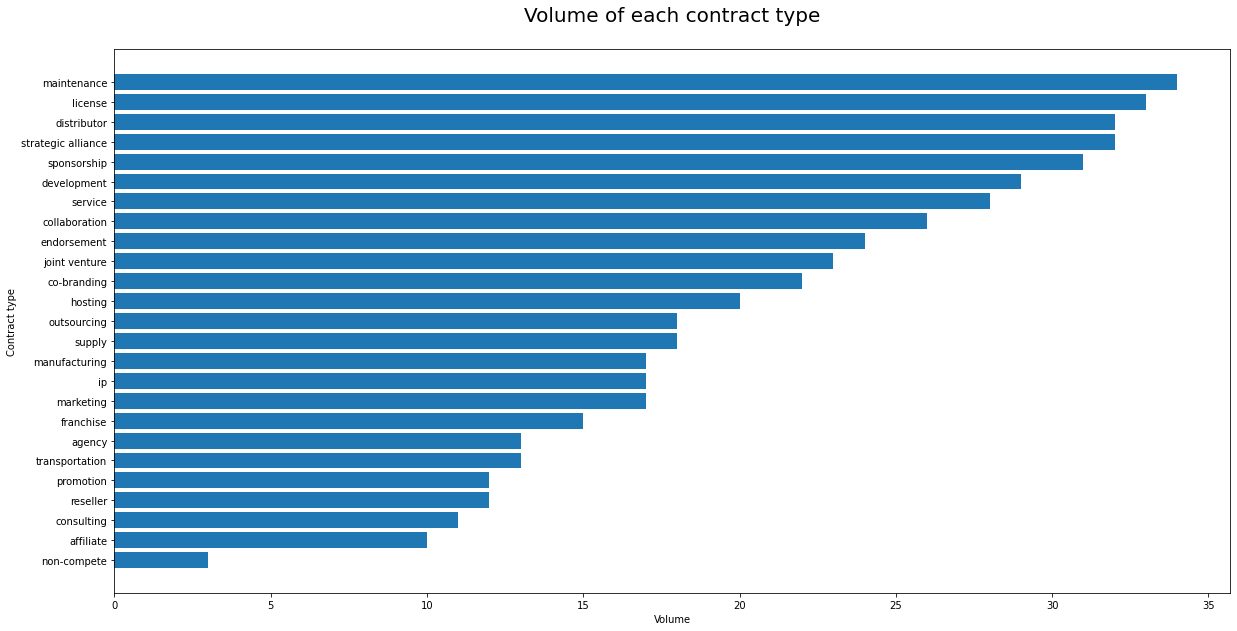

In [369]:
#Count types of contracts
contract_type_count = Counter(raw_contracts['label'])

#Extract raw count values and sort
counts = np.array(list(contract_type_count.values()))
idx = np.argsort(counts)

#Numpy function to strip 'agreements' from each label
vf = np.vectorize(lambda x: x.replace(' agreement', ''))

#re order counts by idx order and define coresponding labels
counts = counts[idx]
labs = np.array(vf(list(contract_type_count.keys()))[idx])

#Plot frequency of each contract type
plt.figure(figsize=(20,10))
plt.barh(labs,counts)
plt.title('Volume of each contract type\n',size =20)
plt.xlabel('Volume')
plt.ylabel('Contract type')
plt.show()

### Clause Count

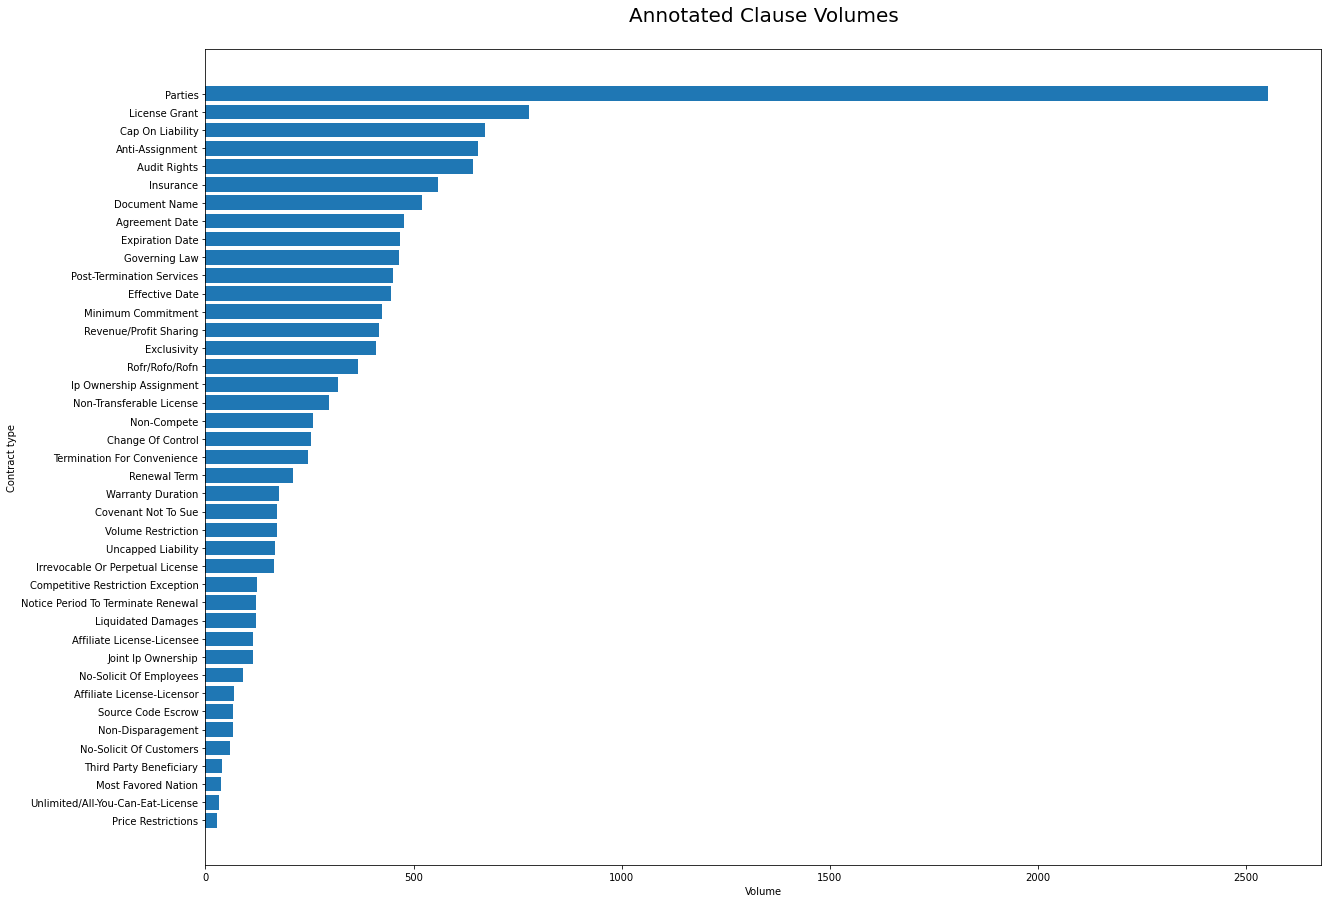

There are 41 clauses in the data


In [370]:
#Count types of contracts
clause_type_count = Counter(clause_data['clause'])

#Extract raw count values and sort
counts = np.array(list(clause_type_count.values()))
idx = np.argsort(counts)

#re order counts by idx order and define coresponding labels
counts = counts[idx]
labs = np.array(list(clause_type_count.keys()))[idx]

#Plot frequency of each contract type
plt.figure(figsize=(20,15))
plt.barh(labs,counts)
plt.title('Annotated Clause Volumes\n',size =20)
plt.xlabel('Volume')
plt.ylabel('Contract type')
plt.show()

print('There are {} clauses in the data'.format(len(labs)))

### Clauses Per Contract

In [371]:
#Count types of contracts
clauses_per_contract = Counter(clause_data['contract title'])

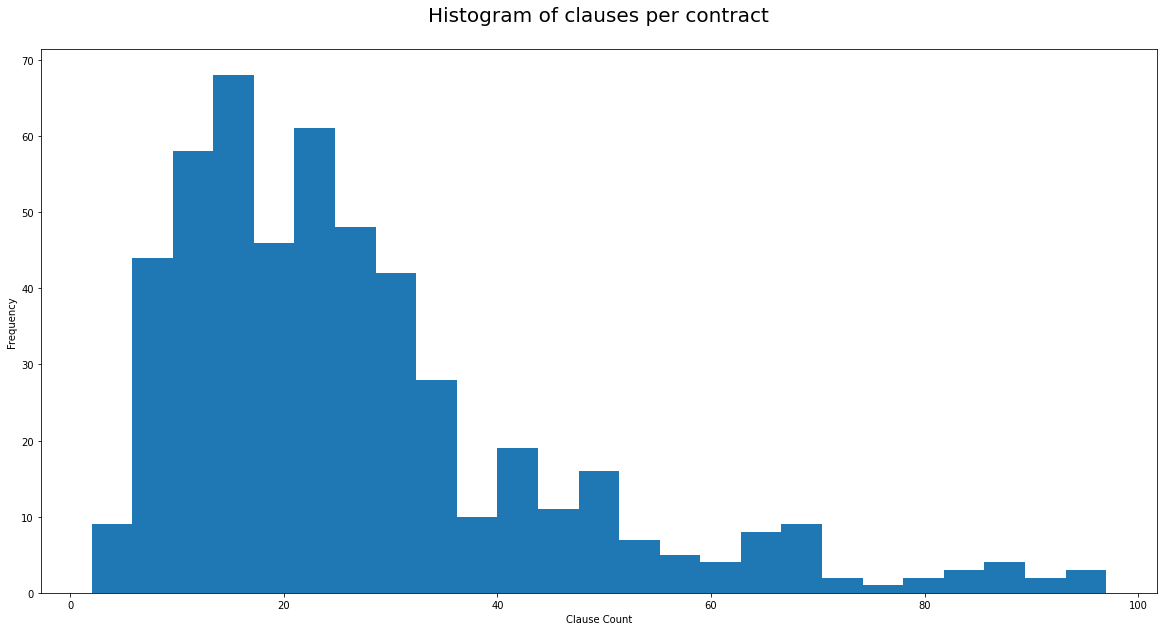

In [372]:
clause_counts = list(clauses_per_contract.values())

plt.figure(figsize =(20,10))
plt.title('Histogram of clauses per contract\n',size = 20)
plt.xlabel('Clause Count')
plt.ylabel('Frequency')
plt.hist(clause_counts,bins = 25)
plt.show()

### Relationship Between Counts of Characters, Sentances and Tokens and Clauses Annotated

In [373]:
from scipy.optimize import curve_fit

def ExpFunc(x, a, b):
    """Exponentional Function to plot a linear line on a log log plot"""
    return a*np.power(x,b)

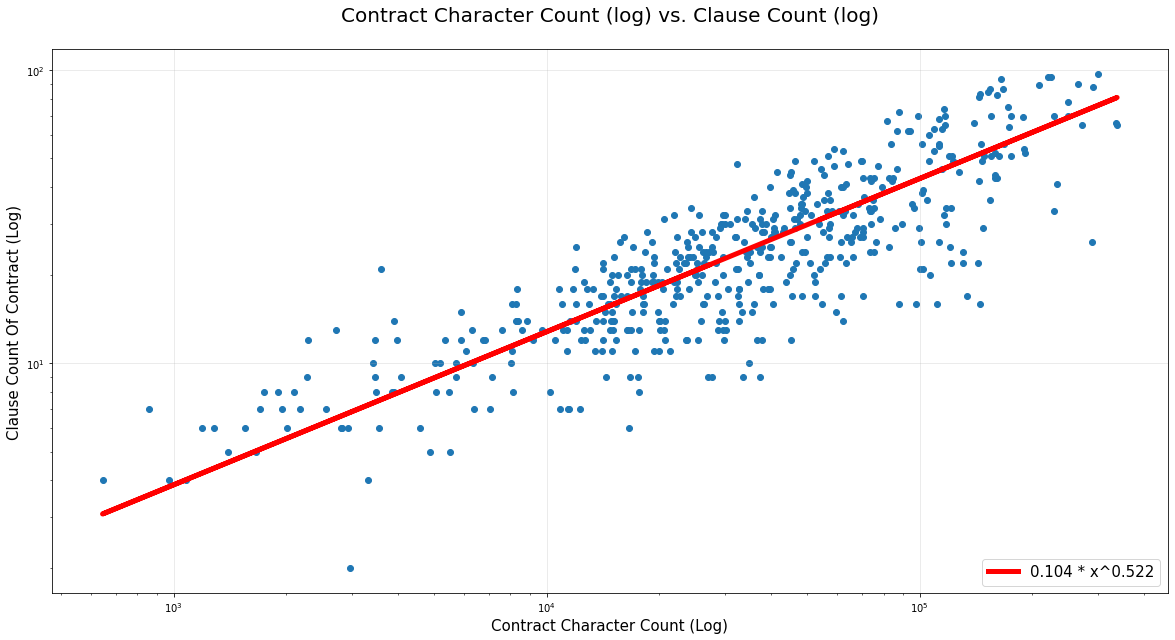

pcov:
[[ 0.00044972 -0.0003775 ]
 [-0.0003775   0.00031865]]

SD:
[0.0212066 0.0178508]


In [374]:
#Define values to plot
xvals = np.array(raw_contracts['character count'])
yvals = np.array([clauses_per_contract[x] for x in raw_contracts['contract title'] ])

#Fit ExpFunc to data
popt, pcov = curve_fit(ExpFunc, xvals, yvals)
perr = np.sqrt(np.diag(pcov))

#Plot Log Log plot od data
plt.figure(figsize =(20,10))
plt.scatter(xvals,yvals)

#Plot fitted line vs the x data on a log scale
plt.plot(xvals,ExpFunc(xvals,*popt), color = 'r', linestyle = '-',linewidth=5, label ='{:.3f} * x^{:.3f}'.format(*popt))

#Format plot
plt.grid(alpha = 0.3)
plt.title('Contract Character Count (log) vs. Clause Count (log)\n', size = 20)
plt.xlabel('Contract Character Count (Log)',size = 15)
plt.ylabel('Clause Count Of Contract (Log)',size = 15)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right',prop={'size': 15})
plt.show()

print('pcov:')
print(pcov)

print('\nSD:')
print(perr)

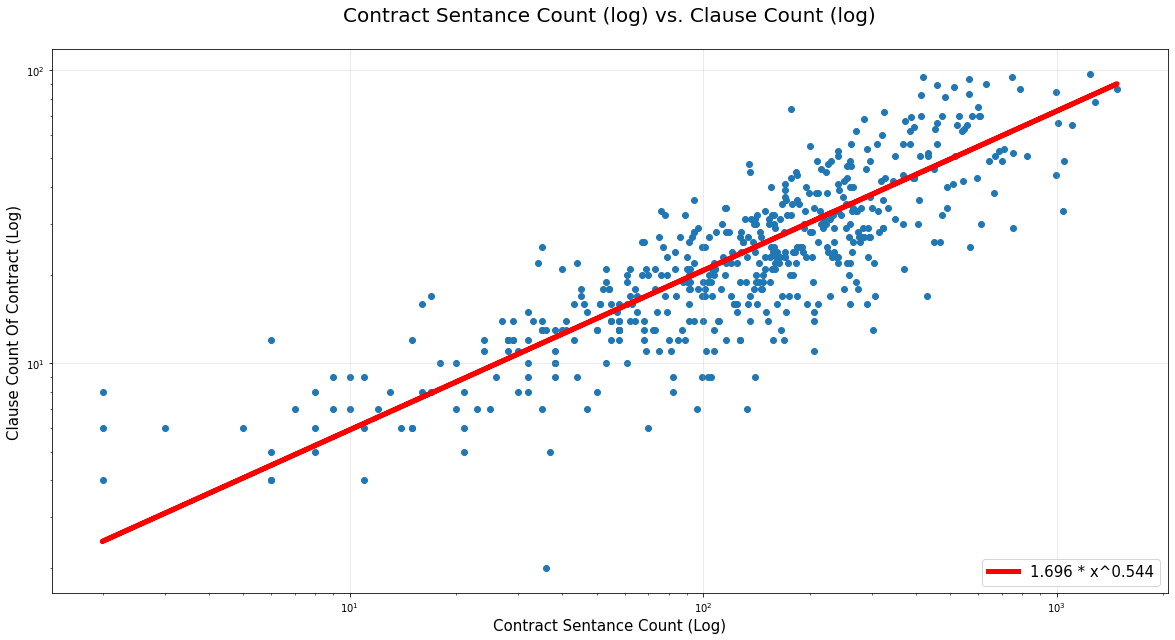

pcov:
[[ 0.03656566 -0.00367674]
 [-0.00367674  0.00037718]]

SD:
[0.19122149 0.01942116]


In [375]:
#Define values to plot
xvals = np.array(raw_contracts['sentance count'])
yvals = np.array([clauses_per_contract[x] for x in raw_contracts['contract title'] ])

#Fit ExpFunc to data
popt, pcov = curve_fit(ExpFunc, xvals, yvals)
perr = np.sqrt(np.diag(pcov))

#Plot Log Log plot od data
plt.figure(figsize =(20,10))
plt.scatter(xvals,yvals)

#Plot fitted line vs the x data on a log scale
plt.plot(xvals,ExpFunc(xvals,*popt), color = 'r', linestyle = '-',linewidth=5, label ='{:.3f} * x^{:.3f}'.format(*popt))

#Format plot
plt.grid(alpha = 0.3)
plt.title('Contract Sentance Count (log) vs. Clause Count (log)\n', size = 20)
plt.xlabel('Contract Sentance Count (Log)',size = 15)
plt.ylabel('Clause Count Of Contract (Log)',size = 15)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right',prop={'size': 15})
plt.show()

print('pcov:')
print(pcov)

print('\nSD:')
print(perr)


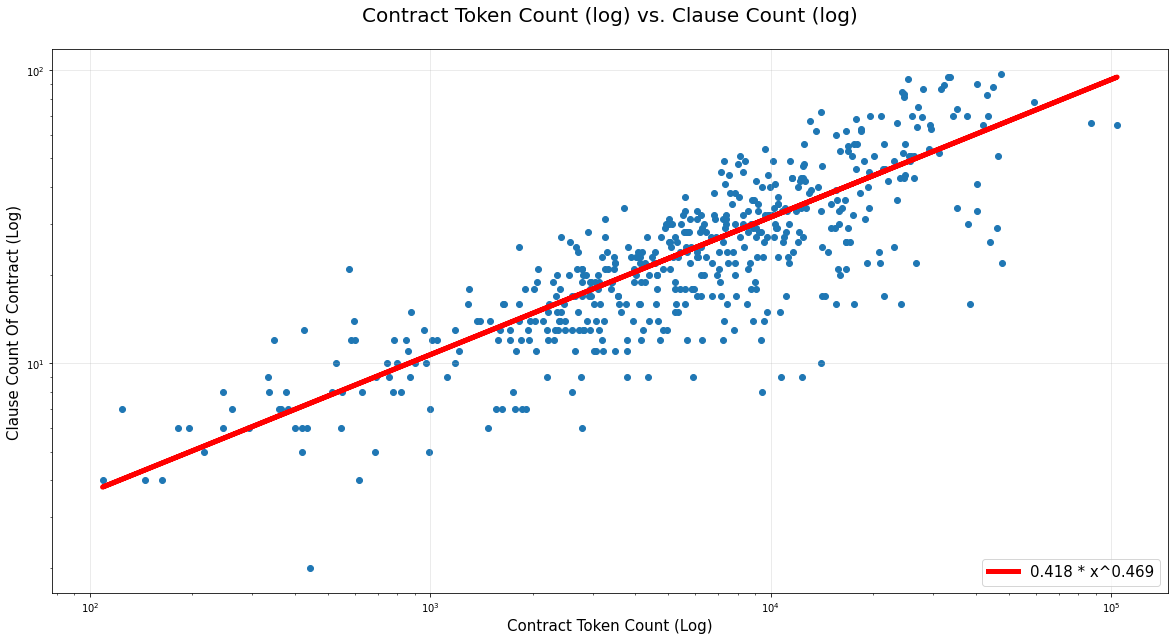

pcov:
[[ 0.0053176  -0.00131239]
 [-0.00131239  0.00032685]]

SD:
[0.07292188 0.01807892]


In [376]:
#Define values to plot
xvals = np.array(raw_contracts['token count'])
yvals = np.array([clauses_per_contract[x] for x in raw_contracts['contract title'] ])

#Fit ExpFunc to data
popt, pcov = curve_fit(ExpFunc, xvals, yvals)
perr = np.sqrt(np.diag(pcov))

#Plot Log Log plot od data
plt.figure(figsize =(20,10))
plt.scatter(xvals,yvals)

#Plot fitted line vs the x data on a log scale
plt.plot(xvals,ExpFunc(xvals,*popt), color = 'r', linestyle = '-',linewidth=5, label ='{:.3f} * x^{:.3f}'.format(*popt))

#Format plot
plt.grid(alpha = 0.3)
plt.title('Contract Token Count (log) vs. Clause Count (log)\n', size = 20)
plt.xlabel('Contract Token Count (Log)',size = 15)
plt.ylabel('Clause Count Of Contract (Log)',size = 15)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right',prop={'size': 15})
plt.show()

print('pcov:')
print(pcov)

print('\nSD:')
print(perr)

### Visualizing Clause Data - Count Vectorization

In [377]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder

In [378]:
clause_lists = defaultdict(list)
contract_labels = {}

for i in range(len(clause_data['clause'])):
  clause_lists[clause_data['contract title'][i]].append(clause_data['clause'][i])
  contract_labels[clause_data['contract title'][i]] = clause_data['label'][i]

#Encode labels of contracts as an integer
LE = LabelEncoder()
LE_labels = LE.fit_transform(list(contract_labels.values()))

For the following cell ref:
https://stackoverflow.com/questions/35867484/pass-tokens-to-countvectorizer

In [379]:
#Determine clause counts (note: this will be impacted by multiple lables)
CV =  CountVectorizer(
      # so we can pass it strings
      input='content',
      # turn off preprocessing of strings to avoid corrupting our keys
      lowercase=False,
      preprocessor=lambda x: x,
      # use our token dictionary
      tokenizer=lambda key: clause_lists[key])

In [380]:
#Count Vectorize clauses
clauses_vectorized = CV.fit_transform(clause_lists).toarray()
#CV.vocabulary_

print('Shape of array {}'.format(clauses_vectorized.shape))

Shape of array (510, 41)


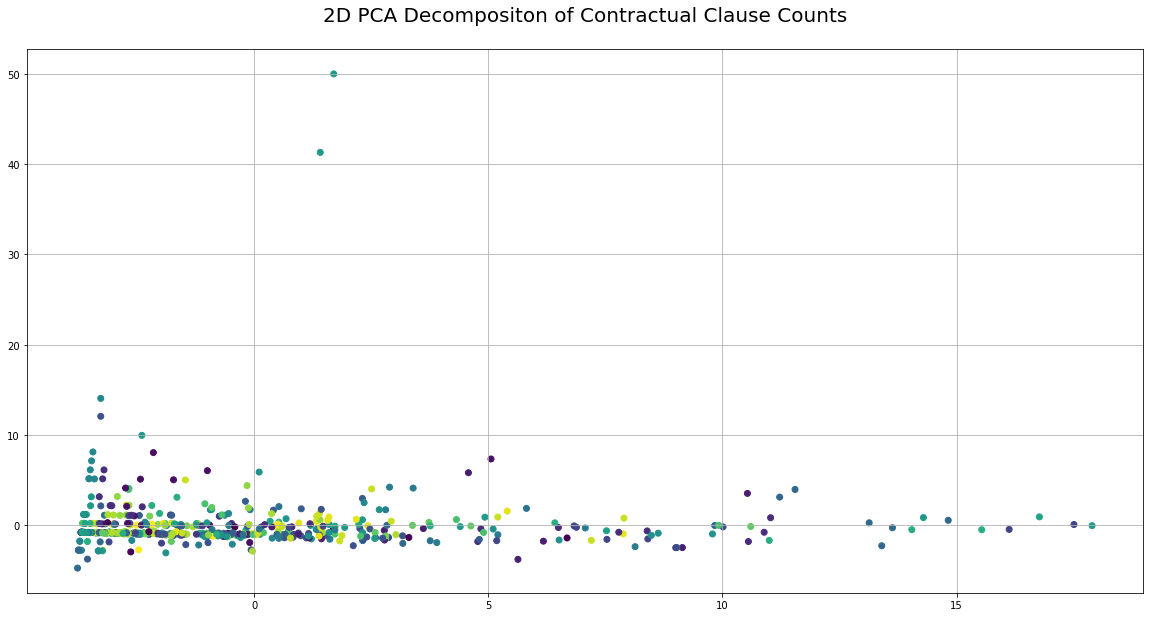

In [381]:
#Decompose clause counts in to 2D via PCA analysis
pca = PCA(n_components=2)
pca_data_2D = pca.fit_transform(clauses_vectorized)

#Extract first two principal components to plot
x = pca_data_2D[:,0]
y = pca_data_2D[:,1]

#Plot first two principal components
plt.figure(figsize = (20,10))
plt.title('2D PCA Decompositon of Contractual Clause Counts\n', size = 20)
plt.scatter(x,y,c = LE_labels)
plt.grid()
plt.show()

### Visualizing Clause Data - TFiDF Vectorization

In [382]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [383]:
#Determine clause counts (note: this will be impacted by multiple lables)
TV =  TfidfVectorizer(
      # so we can pass it strings
      input='content',
      # turn off preprocessing of strings to avoid corrupting our keys
      lowercase=False,
      preprocessor=lambda x: x,
      # use our token dictionary
      tokenizer=lambda key: clause_lists[key])

In [384]:
#Count Vectorize clauses
clauses_vectorized = TV.fit_transform(clause_lists).toarray()
#CV.vocabulary_

print('Shape of array {}'.format(clauses_vectorized.shape))

Shape of array (510, 41)


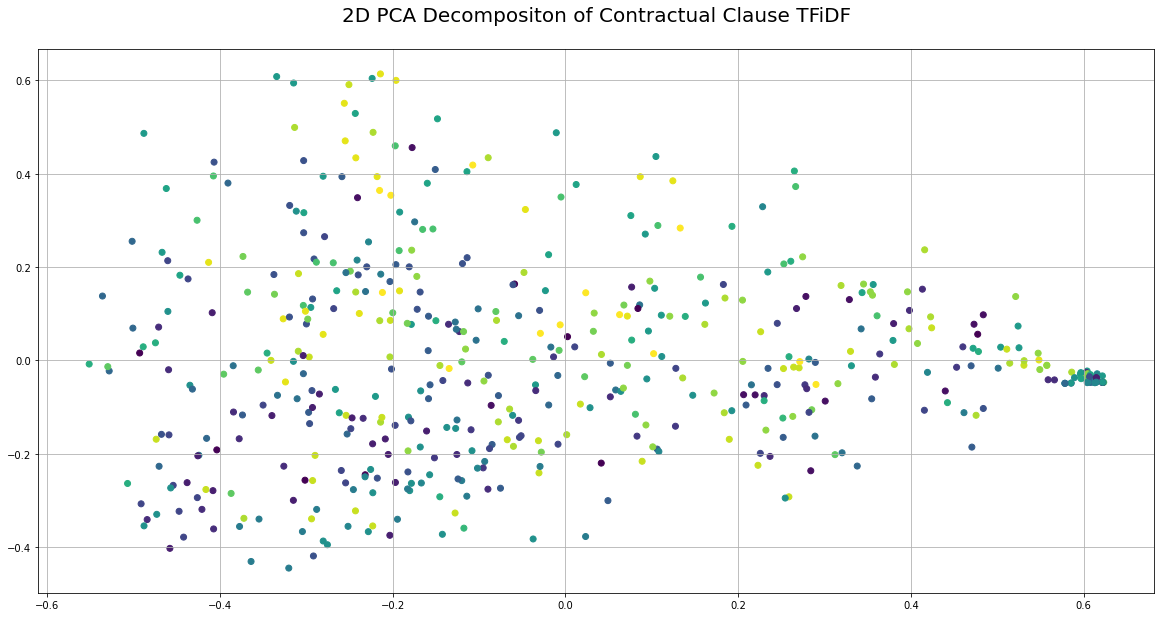

In [385]:
#Decompose clause counts in to 2D via PCA analysis
pca = PCA(n_components=2)
pca_data_2D = pca.fit_transform(clauses_vectorized)

#Extract first two principal components to plot
x = pca_data_2D[:,0]
y = pca_data_2D[:,1]

#Plot first two principal components
plt.figure(figsize = (20,10))
plt.title('2D PCA Decompositon of Contractual Clause TFiDF\n', size = 20)
plt.scatter(x,y,c = LE_labels)
plt.grid()
plt.show()

### Similarity of Contracts Based On Shared Clauses (Using Networks to plot)

Interesting investigation, but no particular value in analysis or output


In [386]:
from sklearn.metrics import jaccard_score, pairwise_distances
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder

In [387]:
clause_lists = defaultdict(list)
contract_labels = {}

for i in range(len(clause_data['clause'])):
  clause_lists[clause_data['contract title'][i]].append(clause_data['clause'][i])
  contract_labels[clause_data['contract title'][i]] = clause_data['label'][i]

In [388]:
contract_names = list(clause_lists.keys())
contract_clauses = list(clause_lists.values())

contract_labels = []
for x in contract_names:
  try:
    contract_labels.append(labels_LU[x])
  except:
    contract_labels.append('marketing agreement')

mlb = MultiLabelBinarizer()
le = LabelEncoder()

contract_clauses_set = ([set(x) for x in contract_clauses])
arr = mlb.fit_transform(contract_clauses_set)
clusters = le.fit_transform(contract_labels)

A = pairwise_distances(arr,arr,metric='jaccard')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [389]:
import networkx as nx
import matplotlib.colors as mcolors

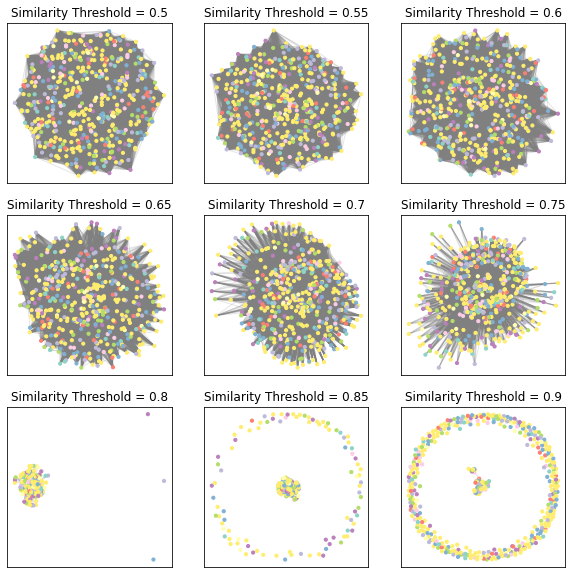

In [390]:
region = 330

plt.figure(figsize=(10,10))
#plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=1, hspace=0.01)

thresh_rng = [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]

for thresh in thresh_rng:
  AA = np.where(A>thresh,1,0)
  G = nx.from_numpy_matrix(AA)

  pos = nx.spring_layout(G) #<-- Set the spring layout
  region += 1

  plt.subplot(region)
  plt.title('Similarity Threshold = {}'.format(thresh))

  nodes = nx.draw_networkx_nodes(G,pos,node_size = 10,cmap = mcolors.ListedColormap(plt.cm.Set3(clusters)),node_color=list(clusters))
  edges = nx.draw_networkx_edges(G,pos,edge_color = 'grey',alpha = 0.2)

plt.show()